In [1]:
import sympy
from mira.metamodel import *
from mira.modeling.viz import GraphicalModel

In [2]:
p = lambda: Concept(name='p')
r = lambda: Concept(name='r')

t2 = NaturalDegradation(subject=r())
t2.set_mass_action_rate_law('V')
t3 = ControlledProduction(controller=r(), outcome=p())
t3.set_mass_action_rate_law('L')
t4 = NaturalDegradation(subject=p())
t4.set_mass_action_rate_law('U')

params = {'V': Parameter(name='V', value=0.03),
          'L': Parameter(name='L', value=2),
          'U': Parameter(name='U', value=0.15)}

initials = {
    'p': Initial(concept=p(), expression=sympy.Float(100)),
    'r': Initial(concept=r(), expression=sympy.Float(3))
}
    

tm = TemplateModel(
    templates=[t2, t3, t4],
    parameters=params,
    initials=initials
    )

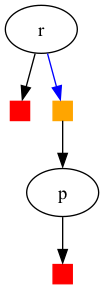

In [3]:
GraphicalModel.for_jupyter(tm)

In [4]:
chen_tm = stratify(tm,
                   key='species',
                   strata=['1', '2', '3'],
                   structure=[],
                   cartesian_control=False)

for i in range(1, 4):
    t = ControlledProduction(controller=Concept(name='p_1', context={'species': '1'}),
                             outcome=Concept(name=f'r_{i}', context={'species': i}))
    t.set_mass_action_rate_law(f'C_{i-1}')
    chen_tm.parameters[f'C_{i-1}'] = Parameter(name=f'C_{i-1}', value=0.03)
    chen_tm.templates.append(t)

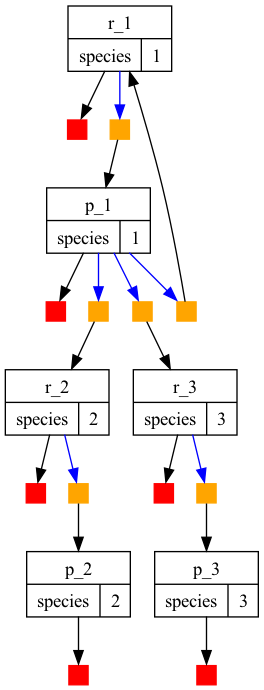

In [5]:
GraphicalModel.for_jupyter(chen_tm)

In [6]:
params = {
    'V': [0.3, 0.3, 0.3],
    'U': [0.15, 0.15, 0.015],
    'C': [0.03, 0.03, 0.024],
}
inits = {
    'r': [3, 6, 5],
    'p': [100, 500, 1],
}
for k, v in params.items():
    for idx, val in enumerate(v):
        chen_tm.parameters[f'{k}_{idx}'].value = v
for k, v in inits.items():
    for idx, val in enumerate(v):
        chen_tm.initials[f'{k}_{idx + 1}'].expression = sympy.Float(val)